In [1]:
import cv2
import os
import csv
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
class_names = {1: 'EOSINOPHIL', 2: 'LYMPHOCYTE', 3: 'MONOCYTE', 4:'NEUTROPHIL'}

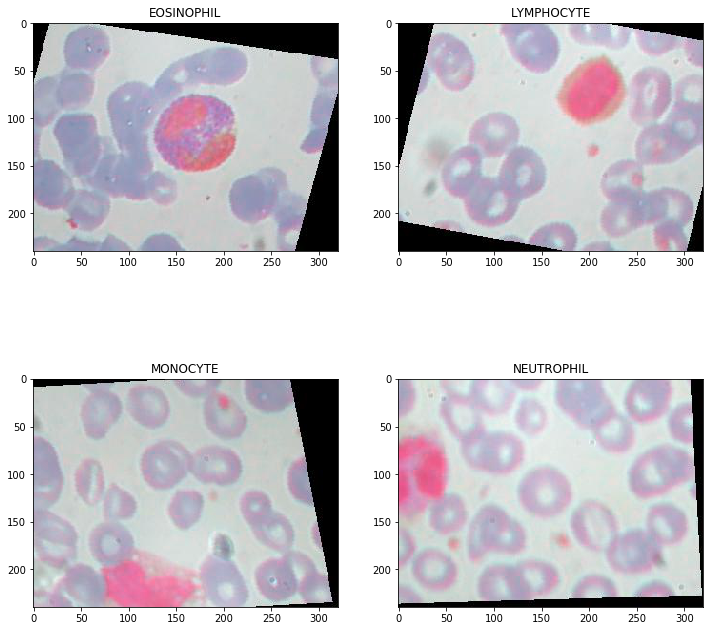

In [3]:
images = [
    'dataset2-master/images/TRAIN/EOSINOPHIL/_0_1169.jpeg',
    'dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg',
    'dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg',
    'dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
]
fig = plt.figure(figsize=(12, 12))

for i in range(1, 5):
    img = cv2.imread(images[i-1])
    fig.add_subplot(2, 2, i)
    plt.title(class_names[i])
    plt.imshow(img)
plt.show()

In [4]:
training_data_folder = 'dataset2-master/images/TRAIN/'
testing_data_folder = 'dataset2-master/images/TEST/'

In [5]:
wbc_labels = {'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL':4}

In [6]:
import scipy.misc
from tqdm import tqdm
def get_data(folder):
    data = []
    labels = []
    for wbc_type in os.listdir(folder):
        for file in tqdm(os.listdir(folder + wbc_type)):
            img_file = cv2.imread(folder + wbc_type + '/' + file)
            if img_file is not None:
                img_file = Image.fromarray(img_file)
                img_file = img_file.resize((100,75),3)
                img_arr = np.asarray(img_file)
                data.append(img_arr)
                labels.append(wbc_labels[wbc_type])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [7]:
training_data, training_labels = get_data(training_data_folder)
testing_data, testing_labels = get_data(testing_data_folder)

100%|██████████| 620/620 [00:01<00:00, 413.25it/s]


{'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL': 4}


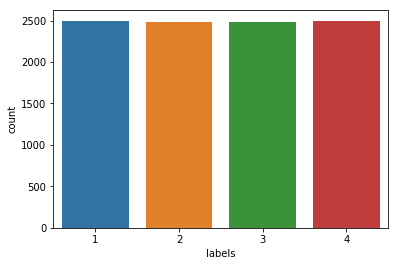

In [8]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=training_labels
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(wbc_labels)

In [9]:
training_data=np.array(training_data)
training_data=training_data/255.0

testing_data=np.array(testing_data)
testing_data=testing_data/255.0

In [10]:
from keras.utils.np_utils import to_categorical
training_label_hot = to_categorical(training_labels, num_classes=5)
testing_label_hot = to_categorical(testing_labels, num_classes=5)
print(wbc_labels)

Using TensorFlow backend.


{'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL': 4}


In [11]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [12]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [13]:
model = applications.ResNet50(weights='imagenet', include_top=False,
                              input_shape=(75, 100, 3))

# for layer in model.layers[:]:
#     layer.trainable = False

x = model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy",
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=["accuracy"])

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)
# Train the model 
history = model_final.fit_generator(
  datagen.flow(training_data, training_label_hot, batch_size=24),
  steps_per_epoch = len(training_data)/32,
  epochs = 32,
  validation_data = [testing_data, testing_label_hot],
  callbacks = [MetricsCheckpoint('logs')])

Instructions for updating:
Colocations handled automatically by placer.


/home/ronald/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ronald/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Instructions for updating:
Use tf.cast instead.
Epoch 1/32
312/311 [==============================] - 845s 3s/step - loss: 0.9169 - acc: 0.6436 - val_loss: 0.9992 - val_acc: 0.6739
Epoch 2/32
312/311 [==============================] - 831s 3s/step - loss: 0.3305 - acc: 0.8690 - val_loss: 1.2012 - val_acc: 0.6819
Epoch 3/32
312/311 [==============================] - 830s 3s/step - loss: 0.2055 - acc: 0.9210 - val_loss: 1.5296 - val_acc: 0.6932
Epoch 4/32
312/311 [==============================] - 830s 3s/step - loss: 0.1615 - acc: 0.9372 - val_loss: 1.3839 - val_acc: 0.7270
Epoch 5/32
312/311 [==============================] - 830s 3s/step - loss: 0.1143 - acc: 0.9587 - val_loss: 1.5469 - val_acc: 0.7258
Epoch 6/32
312/311 [==============================] - 830s 3s/step - loss: 0.0977 - acc: 0.9637 - val_loss: 1.6897 - val_acc: 0.7250
Epoch 7/32
312/311 [==============================] - 830s 3s/step - loss: 0.0787 - acc: 0.9742 - val_loss: 1.4851 - val_acc: 0.7523
Epoch 8/32
312/311 [=

In [14]:
model.save_weights('resnet.h5')
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [15]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 pool1_pad
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a

In [16]:
score = model_final.evaluate(testing_data, testing_label_hot, verbose=0)
print('\nResNet model - accuracy:', score[1],'\n')


ResNet model - accuracy: 0.7450743867754697 



In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn

/home/ronald/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [18]:

def plotResNetLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

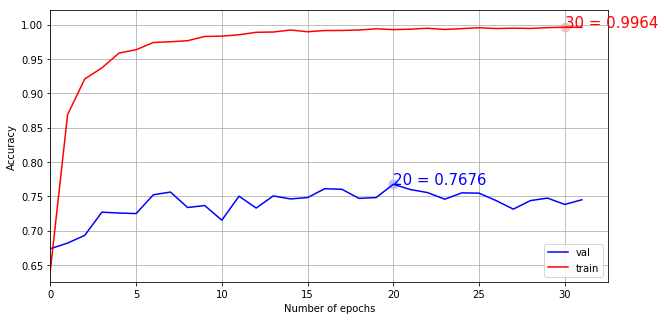

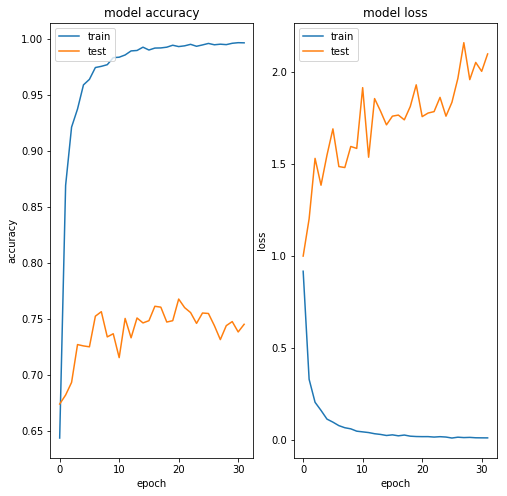

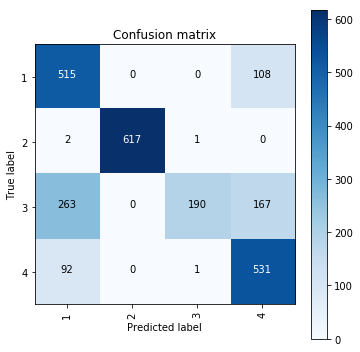

In [19]:
y_pred = model_final.predict(testing_data)
map_characters = wbc_labels
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(testing_label_hot,axis=1)
plotResNetLearningCurve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(wbc_labels.values())) 
plt.show()

In [20]:
print('\n', sklearn.metrics.classification_report(
    np.where(testing_label_hot > 0)[1],
    np.argmax(y_pred, axis=1),
    target_names=list(map_characters.keys())), sep='')


              precision    recall  f1-score   support

  EOSINOPHIL       0.59      0.83      0.69       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       0.99      0.31      0.47       620
  NEUTROPHIL       0.66      0.85      0.74       624

   micro avg       0.75      0.75      0.75      2487
   macro avg       0.81      0.74      0.72      2487
weighted avg       0.81      0.75      0.72      2487

